<a href="https://colab.research.google.com/github/Damilola-ops/PacMan-RL/blob/main/Pacman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get update > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg 
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install gym-retro
!pip install stable-baselines3[extra] optuna
!pip install opencv-python

In [ ]:
#navigating  to the directory where the our game ROM  is 
!cd '/content/drive/MyDrive/ROMS'

In [ ]:
#importing our game rom
!python3 -m retro.import '/content/drive/MyDrive/ROMS'

Importing SpaceInvaders-Snes
Importing SpaceInvaders91-Genesis
Importing PacManNamco-Nes
Importing MsPacMan-Genesis
Importing StreetFighterIISpecialChampionEdition-Genesis
Importing MsPacMan-Genesis
Imported 6 games


In [ ]:
#importing the necessary libraries 
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import numpy as np
import random
import matplotlib
import time 
#for visualizing frames 
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
import retro
import optuna
import torch
# PPO algo for RL
from stable_baselines3 import PPO
# Bring in the eval policy method for metric calculation
from stable_baselines3.common.evaluation import evaluate_policy
# Import the sb3 monitor for logging 
# Import the vec wrappers to vectorize and frame stack
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
#a function to record and display the content of our environment as a video
def showvid():
  mp4list = glob.glob('video/*.mp4')
  if  len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4,'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print('could not find video')

def wrap_env(env):
  env=RecordVideo(env,'./video')
  return env





In [ ]:
env = wrap_env(retro.make(game='MsPacMan-Genesis'))


In [ ]:
env.close()

In [ ]:
observation = env.reset()

while True:
  
    env.render()
    
    #your agent goes here
    action = env.action_space.sample() 
         
    observation, reward, done, info = env.step(action) 
   
        
    if done: 
      break;
            
env.close()
showvid()

In [ ]:
from gym import Env
from gym.spaces import MultiBinary,Box
import cv2 #for grayscaling



In [ ]:
#creating a custom environment 
class PacMan(Env):
  def __init__(self):
    super().__init__()
    self.game_env = wrap_env(retro.make(game='MsPacMan-Genesis'))
    self.action_space = MultiBinary(12)
    self.observation_space = Box(low=0,high=255,shape=(84,84,1),dtype = np.uint8)
    
  def reset(self):
    #return the first frame 
    obs = self.game_env.reset()
    obs = self.preprocess(obs)
    self.previous_frame = obs 
    self.score=0
    return obs
  def preprocess(self,observation):
    #Grayscaling our frames 
    gray = cv2.cvtColor(observation,cv2.COLOR_BGR2GRAY)
    #resize 
    resize = cv2.resize(gray,(84,84),interpolation=cv2.INTER_CUBIC)
    #add channels value 
    channels = np.reshape(resize,(84,84,1))
    return channels 
  def step(self,action):
    #Take a step 
    obs,reward,done,info = self.game_env.step(action)
    obs = self.preprocess(obs)
    #frame delta 
    frame_delta = obs - self.previous_frame 
    self.previous_frame = obs 
    #reshape the reward function 
    reward = info['score'] - self.score
    self.score = info['score']

    return frame_delta,reward,done,info 
  def render(self,*args,**kwargs):
    self.game_env.render()
  def close(self):
    self.game_env.close()





In [ ]:
env = PacMan()

In [ ]:
env.close()

In [ ]:
env.observation_space.shape

(84, 84, 1)

In [ ]:
obs = env.reset()
obs,reward,done,info = env.step(env.action_space.sample())

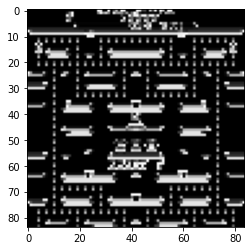

In [ ]:
plt.imshow(cv2.cvtColor(obs, cv2.COLOR_BGR2RGB))

In [ ]:
log_dir = './logs'
opt_dir = './opt/'

In [ ]:
from stable_baselines3.common.monitor import Monitor as monitor
import os 

In [ ]:
os.getcwd()

In [ ]:
#function to return test hyperparameters - define the object function
def optimize_model(trial):
  return {
      'n_steps' : trial.suggest_int('n_steps','2048,8192'),
      'gamma' : trial.suggest_loguniform('gamma',0.8,0.9999),
      'learning_rate': trial.suggest_loguniform('learning_rate',1e-5,1e-4),
      'clip_range' : trial.suggest_uniform('clip_range',0.1,0.4),
      'gae_lambda': trial.suggest_uniform('gae_lambda',0.8,0.99)
  }

In [ ]:
save_path = os.path.join(opt_dir,'trial_{}_best_model'.format(1))

In [ ]:
#run a training loop and return mean reward 
def optimize_agent(trial):
  try:
    model_params = optimize_model(trial)
    #create environment 
    env = PacMan()
    env = Monitor(env,log_dir)
    env = DummyVecEnv([lambda:env])
    env = VecFrameStack(env,4,channels_order='last')
    
    #create RL algorithm
    model = PPO('CnnPolicy',env,tensorboard_log=log_dir,verbose=0,**model_params)
    model.learn(total_timesteps=30000)
    #evaluate model 
    mean_reward,_ = evaluate_policy(model,env,n_eval_episodes=5)
    env.close()
    save_path = os.path.join(opt_dir,'trial_{}_best_model'.format(trial.number))
    return mean_reward
  except Exception as e :
    return -1000 

In [ ]:
#creating the experiment 
study = optuna.create_study(direction='maximize')
study.optimize(optimize_agent,n_trials=10,n_jobs=1)


[I 2022-08-04 22:10:36,271] A new study created in memory with name: no-name-15d807ed-b6b8-4008-afda-98c156dd68cb
[I 2022-08-04 22:10:36,280] Trial 0 finished with value: -1000.0 and parameters: {}. Best is trial 0 with value: -1000.0.
[I 2022-08-04 22:10:36,282] Trial 1 finished with value: -1000.0 and parameters: {}. Best is trial 0 with value: -1000.0.
[I 2022-08-04 22:10:36,284] Trial 2 finished with value: -1000.0 and parameters: {}. Best is trial 0 with value: -1000.0.
[I 2022-08-04 22:10:36,289] Trial 3 finished with value: -1000.0 and parameters: {}. Best is trial 0 with value: -1000.0.
[I 2022-08-04 22:10:36,291] Trial 4 finished with value: -1000.0 and parameters: {}. Best is trial 0 with value: -1000.0.
[I 2022-08-04 22:10:36,293] Trial 5 finished with value: -1000.0 and parameters: {}. Best is trial 0 with value: -1000.0.
[I 2022-08-04 22:10:36,295] Trial 6 finished with value: -1000.0 and parameters: {}. Best is trial 0 with value: -1000.0.
[I 2022-08-04 22:10:36,297] Tria

In [ ]:
study.best_trial

FrozenTrial(number=0, values=[-1000.0], datetime_start=datetime.datetime(2022, 8, 4, 22, 10, 36, 280212), datetime_complete=datetime.datetime(2022, 8, 4, 22, 10, 36, 280369), params={}, distributions={}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)

In [ ]:
#CallBack 
from stable_baselines3.common.callbacks import BaseCallback

In [ ]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [ ]:
checkpoint_dir = './train/'
callback = TrainAndLoggingCallback(check_freq=1000,save_path=checkpoint_dir)

# Training our Model 

In [ ]:
env.close()

In [ ]:
#create env 
env= PacMan()
env = Monitor(env,log_dir)

env = DummyVecEnv([lambda:env])
env = VecFrameStack(env,4,channels_order='last')


In [ ]:
model_params = study.best_params 
model_params['n_steps'] = 7488
model_params

{'n_steps': 7488}

In [ ]:
??PPO

In [ ]:
model = PPO('CnnPolicy',env,tensorboard_log=log_dir,verbose=1,**model_params)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [ ]:
#start training
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.73e+03 |
|    ep_rew_mean     | 370      |
| time/              |          |
|    fps             | 244      |
|    iterations      | 1        |
|    time_elapsed    | 30       |
|    total_timesteps | 7488     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.63e+03    |
|    ep_rew_mean          | 280         |
| time/                   |             |
|    fps                  | 231         |
|    iterations           | 2           |
|    time_elapsed         | 64          |
|    total_timesteps      | 14976       |
| train/                  |             |
|    approx_kl            | 0.019069245 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.31       |
|    explained_variance   | -0.000421   |
|    l

In [ ]:
model.save('test-model')

# Evaluate our Model

In [ ]:
model = PPO.load('/content/train/best_model_104000.zip')
mean_reward,_ = evaluate_policy(model,env,render=True,n_eval_episodes=1)

In [ ]:
mean_reward

360.0

#Testing out our model 

In [ ]:
obs = env.reset()
obs.shape

(1, 84, 84, 4)

In [ ]:
env.close()

In [ ]:
env = wrap_env(retro.make(game='MsPacMan-Genesis'))

In [ ]:
env.reset()

In [ ]:
obs = env.reset()
while True :
  env.render
  action = model.predict(obs)[0]
  obs,reward,done,info = env.step(action)
  time.sleep(0.01)
  print(reward)
  if done:
    env.reset()




In [ ]:
showvid()